In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import html
import urllib

#from helper_functions import *

Reading data
------------

In [20]:
# Marie-Lou's path
graphs_path = './data/wikispeedia_paths-and-graph/'

In [30]:
!ls ./data/wikispeedia_paths-and-graph/

articles.tsv	links.tsv	    paths_unfinished.tsv
categories.tsv	paths_finished.tsv


In [31]:
# Matthew's Path
# graphs_path = '../ADA_Project_Milestone_2_final/data/wikispeedia_paths-and-graph/'

In [32]:
def read_tsv(file_name, names=None):
    
    file_path = graphs_path + f'{file_name}.tsv'
    
    if not names:
        with open(file_path, 'r') as file:
            for line in file:
                if 'FORMAT' in line:
                    format_line = line
                    break

        names = format_line.split()[2:]
    
    return pd.read_csv(file_path,
                           delimiter='\t', comment='#', header=0, names=names)

In [33]:
link_network = read_tsv('links', names=['source', 'target'])
categories = read_tsv('categories')
finished_paths = read_tsv('paths_finished')
unfinished_paths = read_tsv('paths_unfinished')
articles = read_tsv('articles')

Functions
------------

In [34]:
def article_length(article_name):
    ''' Compute the average length of an article, i.e. the number of words'''
    article_path = './data/plaintext_articles/'
    article = article_path + article_name + '.txt'
    
    nb_words = 0
    with open(article) as f:
        for line in f:
            nb_words += len(line.split())
    return nb_words

def get_avg_duration(row):
    ''' Compute the average duration spent per articles'''
    num_steps = len(row['path'].split(';')) - 1
    return np.nan if num_steps <= 0 else row['durationInSec'] / num_steps

def avg_article_length(path):
    '''Compute the average article lenght (i.e. nb of words) along a path of articles'''
    avg_article_length = []
    for index, row in path.iterrows():
        articles = row['path'].split(';')
        articles_length = []
        for art in articles:
            if art != '<': #Not considering backcliks
                articles_length.append(article_length(art))
        avg_article_length.append(np.mean(articles_length))
    return avg_article_length

def avg_target_source_ratio(path):
    ''' Compute the average ratio of incoming and outgoing links in articles along a path'''
    avg_target_source_ratio = []
    for index, row in path.iterrows():
        articles = row['path'].split(';')
        target_source_ratio = []
        if '<' in articles: #Not considering backcliks
            target_source_ratio.append(float('nan'))
        else:
            for art in articles:
                if art in list(link_counts['article']):
                    target_source_ratio.append(link_counts[link_counts['article']==art]['target_source_ratio'].values[0])
                else:
                    target_source_ratio.append(float('nan'))
        avg_target_source_ratio.append(np.nanmean(target_source_ratio))
    
    return avg_target_source_ratio

def calculate_positions(arts):
    ''' Compute the relative position of links clicked in a path'''
    # ignore backclicks
    if '<' in arts: return [float('nan')]
    
    articles = arts.split(';')
    
    # ignore paths without actual steps
    if len(articles) < 2: return [float('nan')]
    
    positions = []
    
    art_idx = 0
    
    for idx, art in enumerate(articles[1:]):
        art0 = articles[art_idx]
        try:          
            positions.append(link_network_pos[(link_network_pos['source'] == art0)
                            & (link_network_pos['target'] == art)]['position'].values[0])
            art_idx = idx+1
        except:
            print(art0, art, arts)
            return [float('nan')]
    
    return positions

def normalize(data, column_name):
    ''' Normalize a column in a dataframe '''
    return (data[column_name] - data[column_name].mean())/data[column_name].std()

Phase 2: Exploratory Data Analysis
------------

### Article metrics

In [35]:
# Ratio of of incoming and outgoing links for each article: 
source_counts = link_network['source'].value_counts().rename_axis('article').reset_index(name='source_count')
target_counts = link_network['target'].value_counts().rename_axis('article').reset_index(name='target_count')

link_counts = pd.merge(source_counts, target_counts, how='outer')
link_counts.fillna(0, inplace=True)

link_counts['target_source_ratio'] = link_counts['target_count'] / link_counts['source_count']
link_counts['target_source_ratio'].replace([np.inf], np.nan, inplace=True)

In [36]:
display(link_counts.head(5))
link_counts.shape

,article,source_count,target_count,target_source_ratio
0,United_States,294.0,1551.0,5.275510
1,Driving_on_the_left_or_right,255.0,0.0,0.000000
2,List_of_countries,244.0,63.0,0.258197
3,List_of_circulating_currencies,236.0,8.0,0.033898
4,List_of_sovereign_states,216.0,43.0,0.199074


(4594, 4)

In [37]:
# Length of articles (i.e. nb of words):
link_counts['article_length'] = link_counts['article'].apply(lambda x: article_length(x))

FileNotFoundError: [Errno 2] No such file or directory: './data/plaintext_articles/United_States.txt'

In [ ]:
display(link_counts.head(5))
link_counts.shape

In [ ]:
# Positions of links within the articles:

# Remove links to and from non-Wikipedia articles (donation pages)
#link_network = filter_rows_by_values(link_network, 'source', ['Friend_Directdebit', 'Sponsorship_Directdebit'])
#link_network_targets = link_network.groupby('source')['target'].apply(list).reset_index()

# Add the 'html_position' column to the DataFrame
#link_network_targets['html_position'] = link_network_targets.apply(
#    lambda row: find_html_position(row['source'], row['target']), axis=1
#)

#display(link_network_targets.head(5))
#link_network_targets.shape

In [9]:
# Load the data 
link_network_pos = pd.read_pickle('link_network_w_position.df')

In [10]:
display(link_network_pos.head(5))
link_network_pos.shape

,source,target,position
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,0.037459
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,0.025523
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,0.058024
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,0.032042
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,0.063349


(119878, 3)

In [11]:
# Identify main categories and sublevels of categories:
main_cat_set = set()
sec_cat_set = set()
thrd_cat_set = set()

for cat in categories['category']:
    levels = cat.split('.')
    if len(levels) > 1:
        main_cat_set.add(levels[1])
    if len(levels) > 2:
        sec_cat_set.add(levels[2])
    if len(levels) > 3:
        thrd_cat_set.add(levels[3])

In [12]:
print(f'There are {len(main_cat_set)} unique main categories, {len(sec_cat_set)} unique second level categories, and {len(thrd_cat_set)} unique third level categories.')

There are 15 unique main categories, 101 unique second level categories, and 27 unique third level categories.


### Player path specific metrics

In [13]:
# Average duration per articles:
#finished_paths['avg_duration'] = finished_paths.apply(get_avg_duration, axis=1)
#unfinished_paths['avg_duration'] = unfinished_paths.apply(get_avg_duration, axis=1)

In [ ]:
# Position of links:
#finished_paths['link_positions'] = finished_paths['path'].apply(calculate_positions)
#unfinished_paths['link_positions'] = unfinished_paths['path'].apply(calculate_positions)

In [ ]:
# Average positions of links clicked for each path:
#finished_paths['avg_position'] = finished_paths['link_positions'].apply(
#    lambda x: np.mean(x) if x else np.nan)
#unfinished_paths['avg_position'] = unfinished_paths['link_positions'].apply(
#    lambda x: np.mean(x) if x else np.nan)

In [ ]:
# Average article length:
#finished_paths['avg_article_length'] = avg_article_length(finished_paths)
#unfinished_paths['avg_article_length'] = avg_article_length(unfinished_paths)

In [ ]:
# Average ratio of incoming and outgoing links for all article in paths
#finished_paths['avg_target_source_ratio'] = avg_target_source_ratio(finished_paths)
#unfinished_paths['avg_target_source_ratio'] = avg_target_source_ratio(unfinished_paths)

In [215]:
#finished_paths.to_pickle('finished_paths_w_positions.df')
#unfinished_paths.to_pickle('unfinished_paths_w_positions.df')

In [13]:
# Load data with positions
finished_paths = pd.read_pickle('finished_paths_w_positions.df')
unfinished_paths = pd.read_pickle('unfinished_paths_w_positions.df')

In [14]:
display(finished_paths.head(5))
finished_paths.shape
display(unfinished_paths.head(5))
unfinished_paths.shape

,hashedIpAddress,timestamp,durationInSec,path,rating,link_positions,avg_duration,avg_position,max_position,avg_article_length,avg_target_source_ratio
0,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"[0.16301315265045835, 0.0320129127715381, 0.23...",17.600000,0.161321,0.238708,4322.400000,2.191707
1,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"[0.38341968911917096, 0.04472755782046257, 0.0...",17.250000,0.189159,0.383420,5570.875000,1.300951
2,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,"[0.43304105221203665, 0.2143170488534397, 0.04...",9.250000,0.229568,0.433041,4011.000000,2.223104
3,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,"[0.14806695894778796, 0.055970351133474004, 0....",25.000000,0.284119,0.983090,6885.714286,2.969612
4,5295bca242be81fe,1372890414,110,14th_century;Europe;North_America;United_State...,NaN,"[0.16301315265045835, 0.3061066648732262, 0.43...",18.333333,0.263157,0.432730,4909.000000,3.750072


,hashedIpAddress,timestamp,durationInSec,path,target,type,link_positions,avg_duration,max_position,avg_position,avg_article_length,avg_target_source_ratio
0,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,[nan],1805.00,NaN,NaN,7586.0,2.333333
1,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,"[0.020996711358461928, 0.24676118775557]",606.00,0.246761,0.133879,5604.0,1.773224
2,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,[nan],49.00,NaN,NaN,1327.0,1.950000
3,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,[0.16173641173641173],904.00,0.161736,0.161736,3352.0,1.532377
4,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,"[0.0487655079228596, 0.12396390951476428, 0.50...",502.25,0.507053,0.226594,4338.0,2.724478


(24874, 12)

### Player specific information

In [15]:
players = pd.concat([unfinished_paths, finished_paths])

In [16]:
# Number of games per player
player_game_counts = players.groupby('hashedIpAddress')['path'].count().reset_index()
player_game_counts.columns = ['player_hash', 'games_count']

In [17]:
# Win rate:
player_game_counts['finished_paths_count'] = player_game_counts['player_hash']\
                                             .map(finished_paths['hashedIpAddress']\
                                             .value_counts().fillna(0))
player_game_counts['win_rate'] = player_game_counts['finished_paths_count'] / player_game_counts['games_count']
player_game_counts['win_rate'].fillna(0, inplace=True)

In [18]:
display(player_game_counts.head(5))
player_game_counts.shape

,player_hash,games_count,finished_paths_count,win_rate
0,000386124f307de8,2,1.0,0.5
1,0007183207b6008f,3,3.0,1.0
2,000a09e202e88d10,1,1.0,1.0
3,000a5bac5b7781ea,1,1.0,1.0
4,000a6e585b776c96,1,NaN,0.0


(20866, 4)

Phase 4:  Comparative Analysis and Statistical Modeling
------------

### Feature Impact Assessment

In [25]:
#features = ['avg_article_length', 'avg_position', 'avg_target_source_ratio']

In [32]:
# Binary indicator of whether a player completed a path (1) or not (0):
paths = pd.concat([finished_paths, unfinished_paths])
paths['completion'] = [1]*len(finished_paths) + [0]*len(unfinished_paths)

In [33]:
# Standardize the countinuous features
paths_normalized = paths.copy()
paths_normalized['avg_article_length'] = normalize(paths_normalized, 'avg_article_length')
paths_normalized['avg_position'] = normalize(paths_normalized, 'avg_position')
paths_normalized['avg_target_source_ratio'] = normalize(paths_normalized, 'avg_target_source_ratio')

In [34]:
# Model 1: dependent variable = completion, so logistic regression (binary outcome)
mod1 = smf.logit(formula='completion ~  avg_article_length + avg_position + avg_target_source_ratio', 
                 data=paths_normalized)
res1 = mod1.fit()
print(res1.summary())

Optimization terminated successfully.
         Current function value: 0.565335
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             completion   No. Observations:                56710
Model:                          Logit   Df Residuals:                    56706
Method:                           MLE   Df Model:                            3
Date:                Tue, 05 Dec 2023   Pseudo R-squ.:                0.002341
Time:                        17:57:36   Log-Likelihood:                -32060.
converged:                       True   LL-Null:                       -32135.
Covariance Type:            nonrobust   LLR p-value:                 2.127e-32
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   1.0873      0.010    111.560      0.000       1.068   

In [35]:
variables_model1 = res1.params.index #features
coefficients_model1 = res1.params.values
p_values_model1 = res1.pvalues
standard_errors_model1 = res1.bse.values
res1.conf_int() #confidence intervals

,0,1
Intercept,1.068209,1.106414
avg_article_length,0.022764,0.062388
avg_position,-0.021980,0.016150
avg_target_source_ratio,-0.138252,-0.099012


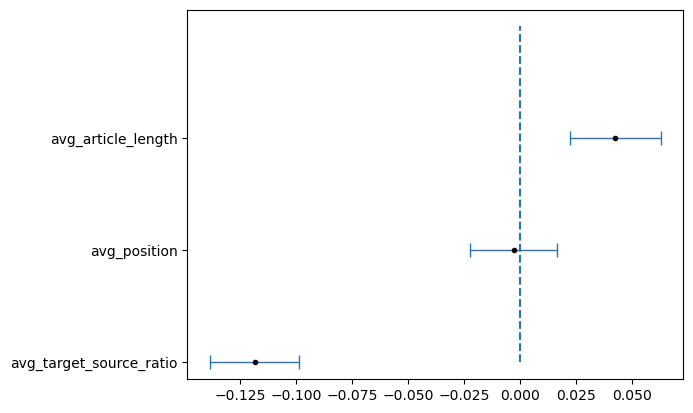

In [36]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model1[1:], variables_model1[1:], 
                                 standard_errors_model1[1:], p_values_model1[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

In [37]:
# Model 2: dependent variable = avg_duration, so linear regression (continuous outcome)
mod2 = smf.ols(formula='avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
                 data=paths_normalized)
res2 = mod2.fit()
print(res2.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:           avg_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.25
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           7.81e-12
Time:                        17:57:42   Log-Likelihood:            -3.7537e+05
No. Observations:               56710   AIC:                         7.508e+05
Df Residuals:                   56706   BIC:                         7.508e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

In [38]:
variables_model2 = res2.params.index #features
coefficients_model2 = res2.params.values
p_values_model2 = res2.pvalues
standard_errors_model2 = res2.bse.values
res2.conf_int() #confidence intervals

,0,1
Intercept,74.973875,77.974198
avg_article_length,-1.257313,1.860246
avg_position,4.102241,7.107048
avg_target_source_ratio,-0.258993,2.975030


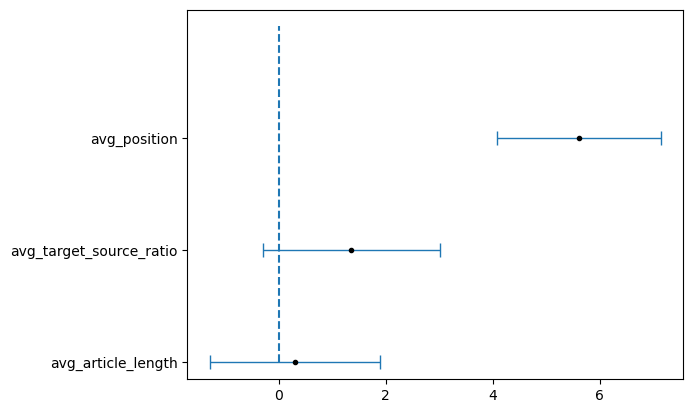

In [39]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model2[1:], variables_model2[1:], 
                                 standard_errors_model2[1:], p_values_model2[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

In [40]:
# Model 2 but with log of avg_duration:
paths_normalized['log_avg_duration'] = np.log(paths_normalized['avg_duration'])

mod2_log = smf.ols(formula='log_avg_duration ~  avg_article_length + avg_position + avg_target_source_ratio', 
                   data=paths_normalized)
res2_log = mod2_log.fit()
print(res2_log.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:       log_avg_duration   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     400.6
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          1.58e-257
Time:                        17:59:19   Log-Likelihood:                -90248.
No. Observations:               56710   AIC:                         1.805e+05
Df Residuals:                   56706   BIC:                         1.805e+05
Df Model:                           3                                         
Covariance Type:            nonrobust  

/Users/marielouhirschy/anaconda3/envs/ada/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [41]:
variables_model2_log = res2_log.params.index #features
coefficients_model2_log = res2_log.params.values
p_values_model2_log = res2_log.pvalues
standard_errors_model2_log = res2_log.bse.values
res2_log.conf_int() #confidence intervals

,0,1
Intercept,3.229529,3.249190
avg_article_length,0.021420,0.041850
avg_position,0.163486,0.183177
avg_target_source_ratio,0.007470,0.028664


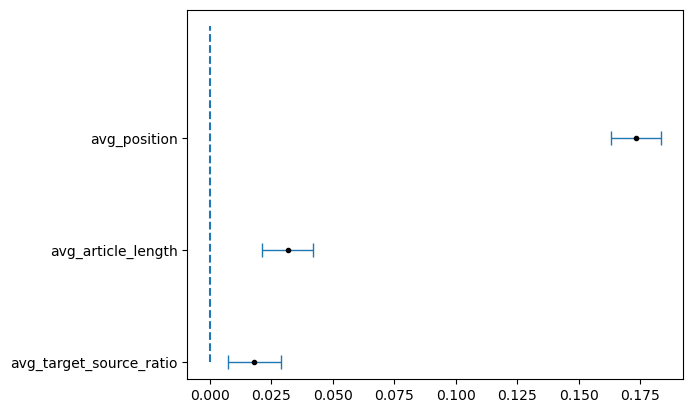

In [42]:
# Sort by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients_model2_log[1:], variables_model2_log[1:], 
                                 standard_errors_model2_log[1:], p_values_model2_log[1:])))

# Plotting
plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)
plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2);

# Hub Characterization Measures

In [40]:
# Create graph of wikispeedia with nodes being articles and edges being links
G_link = nx.from_pandas_edgelist(link_network, 'source', 'target', create_using=nx.DiGraph())


### Centrality Measures

#### Degree Centrality
Degree centrality measures the number of edges that connect to a node (i.e., the degree of the node). The more connections a node has, the more central it is.

For a graph \( G = (V, E) \) with \( n \) vertices, the degree centrality \( C_D(v) \) for a vertex \( v \) is defined as:
$$
C_D(v) = \frac{deg(v)}{n - 1}
$$
where \( deg(v) \) is the degree of \( v \), and \( n - 1 \) is the maximum possible degree of any vertex in a simple graph.

#### Betweenness Centrality
Betweenness centrality measures the extent to which a node lies on paths between other nodes. Nodes that frequently act as bridges between other nodes have higher betweenness centrality.

For a graph \( G = (V, E) \), the betweenness centrality \( C_B(v) \) for a vertex \( v \) is defined as:
$$
C_B(v) = \sum_{s \neq v \neq t \in V} \frac{\sigma_{st}(v)}{\sigma_{st}}
$$
where \( \sigma_{st} \) is the total number of shortest paths from node \( s \) to node \( t \) and \( \sigma_{st}(v) \) is the number of those paths that pass through \( v \).

#### Closeness Centrality
Closeness centrality measures how close a node is to all other nodes in the graph (the sum of the shortest paths from this node to all other nodes). The idea is that nodes closer to others can spread information more efficiently.

For a connected graph \( G = (V, E) \), the closeness centrality \( C_C(v) \) for a vertex \( v \) is defined as:
$$
C_C(v) = \frac{n - 1}{\sum_{u \in V \setminus \{v\}} d(v, u)}
$$
where \( d(v, u) \) is the shortest-path distance between \( v \) and \( u \), and \( n - 1 \) is the number of nodes excluding \( v \) itself.

#### Eigenvector Centrality
Eigenvector centrality assigns relative scores to all nodes in the network based on the principle that connections to high-scoring nodes contribute more to the score of a node than equal connections to low-scoring nodes.

It is calculated by finding the eigenvector associated with the largest eigenvalue of the adjacency matrix \( A \) of the graph \( G \). If \( x \) is the eigenvector centrality of \( G \) and \( \lambda \) is the largest eigenvalue, then:
$$
Ax = \lambda x
$$
The centrality \( x_i \) of the node \( i \) is the \( i \)th element of the eigenvector \( x \).


In [41]:
# Calculating centrality measurement

# Function for Degree Centrality
def get_degree_centrality(G):
    return nx.degree_centrality(G)

# Function for Betweenness Centrality
def get_betweenness_centrality(G):
    return nx.betweenness_centrality(G)

# Function for Closeness Centrality
def get_closeness_centrality(G):
    return nx.closeness_centrality(G)

# Function for Eigenvector Centrality
def get_eigenvector_centrality(G):
    return nx.eigenvector_centrality(G)

In [42]:
# Calculate centralities for wikipedia links
degree_centrality_links = get_degree_centrality(G_link)
betweenness_centrality_links = get_betweenness_centrality(G_link)
closeness_centrality_links = get_closeness_centrality(G_link)
eigenvector_centrality_links = get_eigenvector_centrality(G_link)

# Create a DataFrame for players
centrality_df_links = pd.DataFrame({
    'Node': list(G_link.nodes()),
    'Degree Centrality': [degree_centrality_links[node] for node in G_link.nodes()],
    'Betweenness Centrality': [betweenness_centrality_links[node] for node in G_link.nodes()],
    'Closeness Centrality': [closeness_centrality_links[node] for node in G_link.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality_links[node] for node in G_link.nodes()]
})

print(centrality_df_links)

                                  Node  Degree Centrality  \
0                           linkSource           0.000218   
1                           linkTarget           0.000218   
2     %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                                 Bede           0.008491   
4                              Columba           0.005008   
...                                ...                ...   
4589                      Yellowhammer           0.002830   
4590                    Yotsuya_Kaidan           0.000435   
4591            You%27re_Still_the_One           0.000435   
4592                    Yungay%2C_Peru           0.000871   
4593                        Zara_Yaqob           0.001306   

      Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  
0                   0.000000              0.000000            4.240657e-24  
1                   0.000000              0.000218            5.512854e-23  
2                   0.000000        

### Clustering Coefficients for Directed Graphs

Clustering coefficients measure the likelihood that two neighbors of a node are also neighbors of each other, forming a triangle in the graph. For directed graphs, the concept is extended to account for the directionality of connections.

#### Directed Clustering Coefficients

For a directed graph \( G = (V, E) \), the clustering coefficient can be defined for each node based on the directed triangles they participate in. There are three types of directed triangles:

- **Outgoing Triangles**: Triangles that a node \( v \) points to, i.e., \( v \) has directed edges going out to the other two nodes.
- **Incoming Triangles**: Triangles that point to the node \( v \), i.e., the other two nodes have directed edges going into \( v \).
- **Cyclic Triangles**: Triangles where the edges form a cycle, i.e., each node points to another node in a cyclic manner.

The directed clustering coefficient for a node \( v \) is typically the average of the local clustering coefficients for each type of triangle:

$$
C_{dir}(v) = \frac{1}{3} (C_{out}(v) + C_{in}(v) + C_{cycle}(v))
$$

where \( C_{out}(v) \), \( C_{in}(v) \), and \( C_{cycle}(v) \) are the local clustering coefficients for outgoing, incoming, and cyclic triangles respectively.

The local clustering coefficient for each type of triangle is calculated as:

$$
C_{type}(v) = \frac{\text{Number of triangles of a given type including } v}{\text{Number of possible triangles of that type for } v}
$$

In [43]:
# Calculate clustering coefficients according to formula above
directed_clustering_coefficient = nx.clustering(G_link)
# Put the coefficients in a list for plotting
directed_clustering_values = list(directed_clustering_coefficient.values())


In [44]:

# Convert the dictionary to a Series, aligning on the index with the DataFrame 'Node' column
clustering_coefficients_series = pd.Series(directed_clustering_coefficient)

# Set the 'Node' column as the index for proper alignment
centrality_df_links.set_index('Node', inplace=True)

# Add the Series as a new column to the DataFrame
centrality_df_links['Directed Clustering Coefficients'] = clustering_coefficients_series

# Reset the index if you want 'Node' to be a column again
centrality_df_links.reset_index(inplace=True)

# Now the DataFrame should have a new column with the clustering coefficients
print(centrality_df_links.head())

                               Node  Degree Centrality  \
0                        linkSource           0.000218   
1                        linkTarget           0.000218   
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                              Bede           0.008491   
4                           Columba           0.005008   

   Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  \
0                0.000000              0.000000            4.240657e-24   
1                0.000000              0.000218            5.512854e-23   
2                0.000000              0.000000            4.240657e-24   
3                0.000136              0.355010            3.588548e-03   
4                0.000041              0.331595            1.851423e-03   

   Directed Clustering Coefficients  
0                          0.000000  
1                          0.000000  
2                          0.436364  
3                          0.098782  
4         

### Plot distribution of each centrality measure


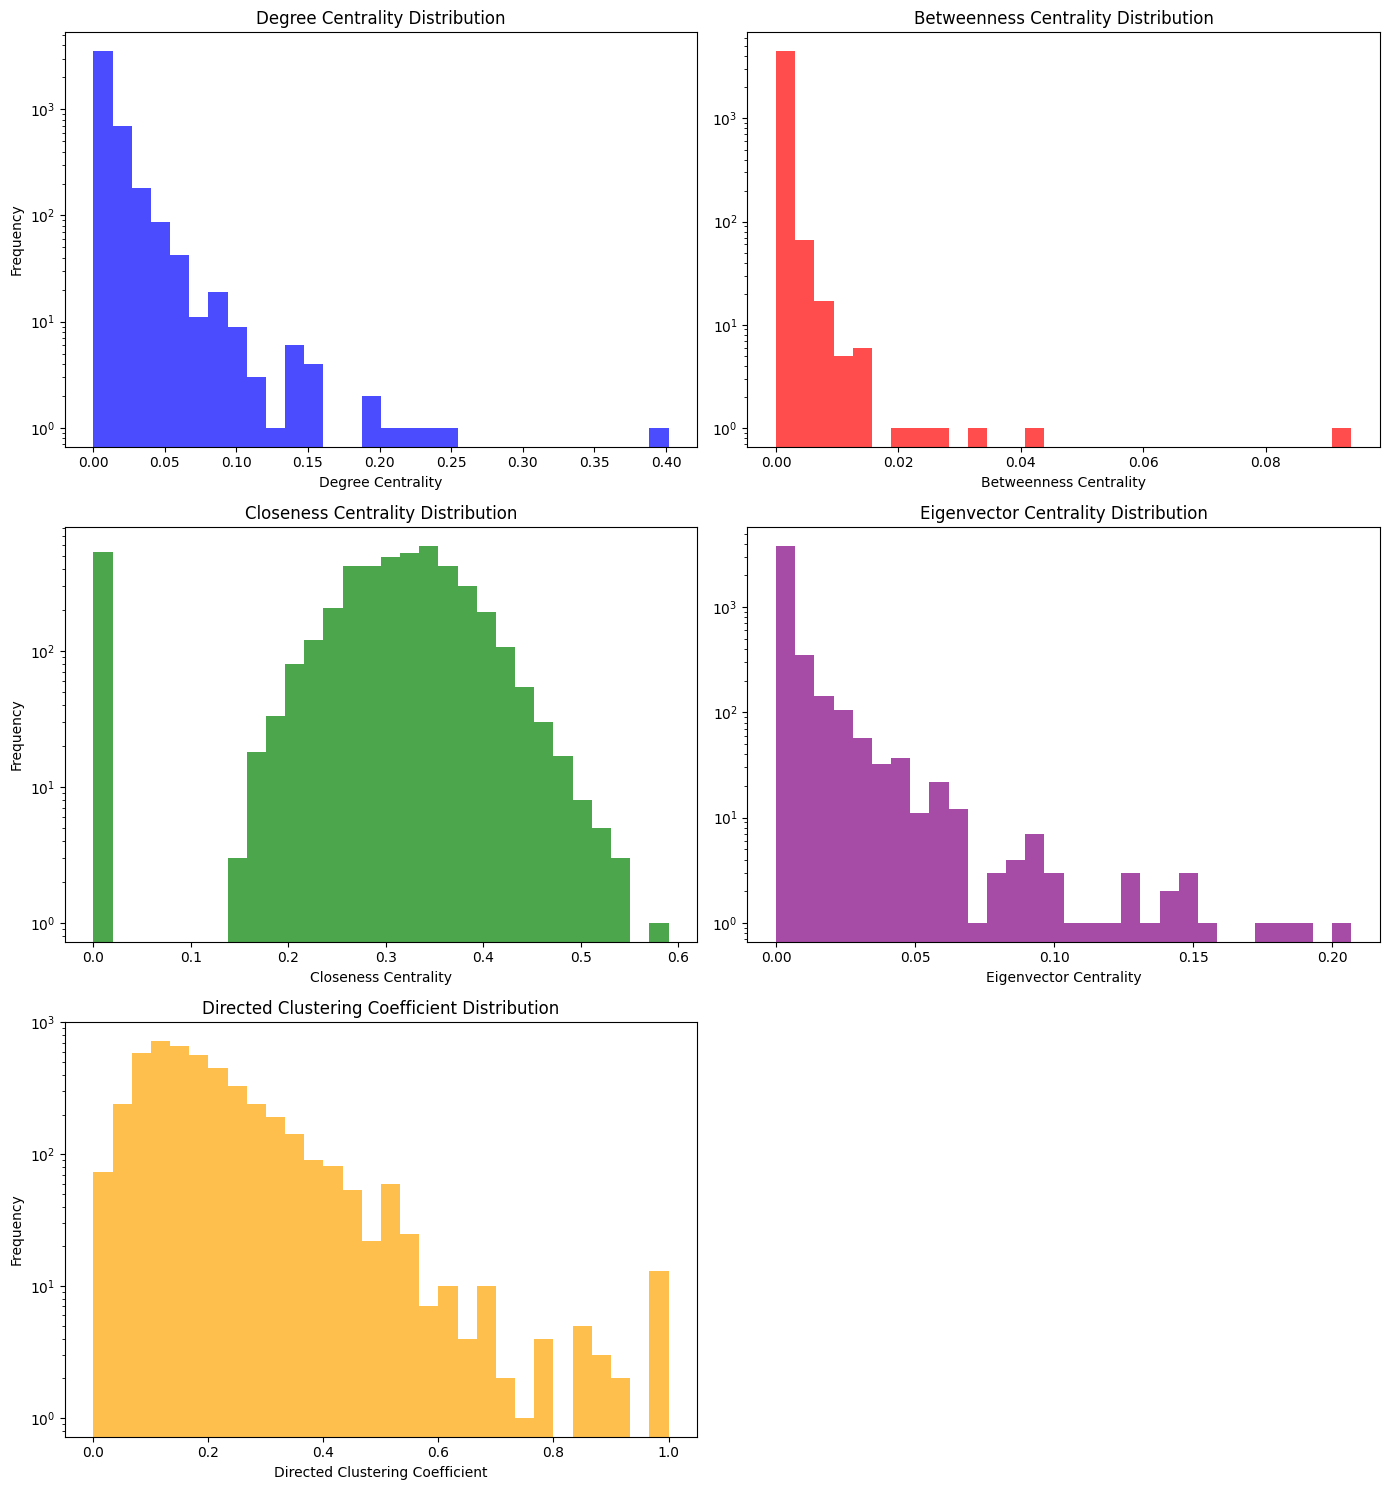

In [45]:
# Plot distribution of each centrality measure

# Set the size of the overall figure
plt.figure(figsize=(14, 15))

# Degree Centrality Distribution
plt.subplot(3, 2, 1)
plt.hist(centrality_df_links['Degree Centrality'], bins=30, color='blue', alpha=0.7,log=True)
plt.title('Degree Centrality Distribution')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

# Betweenness Centrality Distribution
plt.subplot(3, 2, 2)
plt.hist(centrality_df_links['Betweenness Centrality'], bins=30, color='red', alpha=0.7,log=True)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Betweenness Centrality')

# Closeness Centrality Distribution
plt.subplot(3, 2, 3)
plt.hist(centrality_df_links['Closeness Centrality'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

# Eigenvector Centrality Distribution
plt.subplot(3, 2, 4)
plt.hist(centrality_df_links['Eigenvector Centrality'], bins=30, color='purple', alpha=0.7, log=True)
plt.title('Eigenvector Centrality Distribution')
plt.xlabel('Eigenvector Centrality')

# Directed Clustering Coefficient Distribution
plt.subplot(3, 2, 5)  # Adjust to a 3x2 subplot grid
plt.hist(directed_clustering_values, bins=30, color='orange', alpha=0.7, log=True)
plt.title('Directed Clustering Coefficient Distribution')
plt.xlabel('Directed Clustering Coefficient')
plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [46]:
# Calculate standard deviation for each centrality measure
std_devs = centrality_df_links.iloc[:, 1:].std()
print(std_devs)

# Add new columns indicating whether the node's centrality is above the standard deviation (1 if it is, 0 if not)
for centrality_measure in ['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'Directed Clustering Coefficients']:
    centrality_df_links[centrality_measure + ' Above Std'] = (
        centrality_df_links[centrality_measure] > std_devs[centrality_measure]).astype(int)

# Now centrality_df_links has the additional columns with binary values for each centrality measure
print(centrality_df_links.head())  # Displaying just the head for brevity

Degree Centrality                   0.017113
Betweenness Centrality              0.001979
Closeness Centrality                0.116993
Eigenvector Centrality              0.013774
Directed Clustering Coefficients    0.125182
dtype: float64
                               Node  Degree Centrality  \
0                        linkSource           0.000218   
1                        linkTarget           0.000218   
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                              Bede           0.008491   
4                           Columba           0.005008   

   Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  \
0                0.000000              0.000000            4.240657e-24   
1                0.000000              0.000218            5.512854e-23   
2                0.000000              0.000000            4.240657e-24   
3                0.000136              0.355010            3.588548e-03   
4                0.000041           

In [47]:
df_player1 = finished_paths
df_player2 = unfinished_paths

In [48]:
# Define functions to extract the source and target from the path
def extract_source(path):
    return path.split(';')[0] if pd.notnull(path) else None

def extract_target(path):
    return path.split(';')[-1] if pd.notnull(path) else None

# Apply these functions to the 'path' column of df_player1
df_player1['source'] = df_player1['path'].apply(extract_source)
df_player1['target'] = df_player1['path'].apply(extract_target)

# Apply the source extraction function to the 'path' column of df_player2
df_player2['source'] = df_player2['path'].apply(extract_source)


In [49]:
# Add the 'path_finished' column to each DataFrame before concatenating
df_player1['path_finished'] = 1
df_player2['path_finished'] = 0

# Concatenate the two DataFrames into one
df_player = pd.concat([df_player1, df_player2], ignore_index=True)
df_player = df_player.iloc[5:]

# Now df_player will have all the rows from both df_player1 and df_player2
# with the 'path_finished' column indicating from which DataFrame the row came from
print(df_player)


        hashedIpAddress   timestamp durationInSec  \
5      6a3701d319fc3754  1297740409           166   
6      3824310e536af032  1344753412            88   
7      415612e93584d30e  1349298640           138   
8      64dd5cd342e3780c  1265613925            37   
9      015245d773376aab  1366730828           175   
...                 ...         ...           ...   
76192  109ed71f571d86e9  1389787605           180   
76193  232f992e57d43e8d  1389787697             6   
76194  2e09a7224600a7cd  1389798400          1900   
76195  60af9e2138051b96  1389799481          1903   
76196  1cf0cbb3281049ab  1389822841           352   

                                                    path rating  \
5      14th_century;15th_century;16th_century;Pacific...    NaN   
6      14th_century;Europe;Africa;Atlantic_slave_trad...      3   
7      14th_century;Niger;Nigeria;British_Empire;Slav...    NaN   
8         14th_century;Renaissance;Ancient_Greece;Greece    NaN   
9      14th_century;Italy;Ro

In [50]:
# Define a function to count the number of hubs in a path
def count_hubs(path, hubs_set):
    # Split the path into individual nodes
    nodes = path.split(';')
    # Count the number of nodes in the path that are in the set of hubs
    hub_count = sum(node in hubs_set for node in nodes)
    return hub_count

# Create sets of hubs for each centrality measure
hubs_degree = set(centrality_df_links[centrality_df_links['Degree Centrality Above Std'] == 1]['Node'])
hubs_betweenness = set(centrality_df_links[centrality_df_links['Betweenness Centrality Above Std'] == 1]['Node'])
hubs_closeness = set(centrality_df_links[centrality_df_links['Closeness Centrality Above Std'] == 1]['Node'])
hubs_eigenvector = set(centrality_df_links[centrality_df_links['Eigenvector Centrality Above Std'] == 1]['Node'])
hubs_clustering = set(centrality_df_links[centrality_df_links['Directed Clustering Coefficients Above Std'] == 1]['Node'])

# Add the hub count columns to df_player
df_player['Degree Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_degree))
df_player['Betweenness Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_betweenness))
df_player['Closeness Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_closeness))
df_player['Eigenvector Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_eigenvector))
df_player['Clustering Hub Count'] = df_player['path'].apply(lambda path: count_hubs(path, hubs_clustering))


### Get Shortest Path

In [51]:
# Function to calculate the shortest path length
def calculate_shortest_path_length(row, graph):
    try:
        # Compute the shortest path length between source and target
        path_length = nx.shortest_path_length(graph, source=row['source'], target=row['target'])
        return path_length
    except nx.NetworkXNoPath:
        # If there is no path between source and target, return None or some indicator like -1
        return None
    except nx.NodeNotFound:
        # If the source or target node does not exist in the graph, return None or some indicator like -1
        return None

# Apply the function to each row in df_player to calculate the shortest path length
df_player['shortest_path'] = df_player.apply(lambda row: calculate_shortest_path_length(row, G_link), axis=1)


### Count number of different categories


In [52]:
# Step 1: Rename 'article' column to 'Node'
categories.rename(columns={'article': 'Node'}, inplace=True)

# Step 2: Extract the last category element
categories['category'] = categories['category'].apply(lambda x: x.split('.')[-1] if pd.notnull(x) else None)

# Step 3: Create a mapping from 'Node' to 'category'
category_mapping = categories.set_index('Node')['category'].to_dict()

# Step 4: Map the category to the corresponding node in 'centrality_df_links'
centrality_df_links['category'] = centrality_df_links['Node'].map(category_mapping)

In [53]:
print(centrality_df_links)

                                  Node  Degree Centrality  \
0                           linkSource           0.000218   
1                           linkTarget           0.000218   
2     %C3%81ed%C3%A1n_mac_Gabr%C3%A1in           0.002395   
3                                 Bede           0.008491   
4                              Columba           0.005008   
...                                ...                ...   
4589                      Yellowhammer           0.002830   
4590                    Yotsuya_Kaidan           0.000435   
4591            You%27re_Still_the_One           0.000435   
4592                    Yungay%2C_Peru           0.000871   
4593                        Zara_Yaqob           0.001306   

      Betweenness Centrality  Closeness Centrality  Eigenvector Centrality  \
0                   0.000000              0.000000            4.240657e-24   
1                   0.000000              0.000218            5.512854e-23   
2                   0.000000     

In [54]:
# Step 1: Create a mapping from nodes to categories.
node_to_category = pd.Series(centrality_df_links['category'].values, index=centrality_df_links['Node']).to_dict()

# Step 2: Define a function to count unique categories in a path.
def count_unique_categories(path):
    if pd.isna(path):
        return 0
    # Split the path into nodes.
    nodes = path.split(';')
    # Find the category for each node, count unique categories.
    categories = [node_to_category.get(node) for node in nodes if node in node_to_category]
    return len(set(categories))

# Step 3: Apply the function to each row in df_player 'path' column.
df_player['unique_categories'] = df_player['path'].apply(count_unique_categories)


In [55]:
df_player

,hashedIpAddress,timestamp,durationInSec,path,rating,source,target,path_finished,type,Degree Hub Count,Betweenness Hub Count,Closeness Hub Count,Eigenvector Hub Count,Clustering Hub Count,shortest_path,unique_categories
5,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,14th_century,African_slave_trade,1,NaN,6,4,9,6,3,3.0,4
6,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3,14th_century,African_slave_trade,1,NaN,3,2,5,3,2,3.0,4
7,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,14th_century,African_slave_trade,1,NaN,6,3,8,6,4,3.0,6
8,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,14th_century,Greece,1,NaN,4,2,4,4,0,2.0,3
9,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3,14th_century,John_F._Kennedy,1,NaN,6,3,7,4,0,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76192,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,NaN,Franz_Kafka,Cholera,0,restart,6,0,7,4,3,3.0,5
76193,232f992e57d43e8d,1389787697,6,Modern_history,NaN,Modern_history,Hollandic,0,restart,1,0,1,0,0,3.0,1
76194,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,NaN,Computer_programming,The_Beatles,0,timeout,1,0,4,1,1,3.0,3
76195,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,NaN,Jamaica,Alan_Turing,0,timeout,3,2,4,3,1,3.0,4
